In [ ]:
#Here I import necessary tools
import pandas as pd
import numpy as np
#I use wine and iris datasets as sample data.
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
#The following tool is for splitting the data set to train and validation
#dataset.
from sklearn.model_selection import train_test_split
#The following tool is for showing the dataset.
import seaborn as sns

In [ ]:
#The following class is used for creating the branches of the tree for decision 
#tree algorithm.
class Node:
    def __init__(self):
        
        # links to the left and right child nodes
        self.right = None
        self.left = None
        
        # column and threshold would be taken from splitting criteria
        self.column = None
        self.threshold = None
        
        # probability for object inside the Node to belong for each of the given classes
        self.probas = None
        
        # depth of the given node
        self.depth = None
        
        # if it is the root Node or not
        self.is_terminal = False


In [ ]:
class ID3:
    def __init__(self, max_depth = 3, min_samples_leaf = 1, min_samples_split = 2):
        
        self.max_depth = max_depth # THe depth of the tree can't be more than this
        self.min_samples_leaf = min_samples_leaf # Minimum leaf at each end
        self.min_samples_split = min_samples_split # Minimum splitting at each point
        self.classes = None
        self.Tree = None
    
    def nodeProbas(self, y):
        #Calculates probability of class in a given node
        probas = []
        
        for one_class in self.classes:
            proba = y[y == one_class].shape[0] / y.shape[0]
            probas.append(proba)
        return np.asarray(probas)

    def gini(self, probas):
        #Calculates gini criterion
        return 1 - np.sum(probas**2)
    
    def calcImpurity(self, y):
        #Wrapper for the impurity calculation. Calculates probas first and then passses them
        #to the Gini criterion
        return self.gini(self.nodeProbas(y))
    
    def calcBestSplit(self, X, y):
        
        #Calculates the best possible split for the concrete node of the tree
        bestSplitCol = None
        bestThresh = None
        bestInfoGain = -999
        impurityBefore = self.calcImpurity(y)
        
        for col in range(X.shape[1]):
            x_col = X[:, col]
            
            for x_i in x_col:
                threshold = x_i
                y_right = y[x_col > threshold]
                y_left = y[x_col <= threshold]
                
                if y_right.shape[0] == 0 or y_left.shape[0] == 0:
                    continue
                    
                impurityRight = self.calcImpurity(y_right)
                impurityLeft = self.calcImpurity(y_left)
                
                infoGain = impurityBefore
                infoGain -= (impurityLeft * y_left.shape[0] / y.shape[0]) + (impurityRight * y_right.shape[0] / y.shape[0])
                
                if infoGain > bestInfoGain:
                    bestSplitCol = col
                    bestThresh = threshold
                    bestInfoGain = infoGain
                    
        if bestInfoGain == -999:
            return None, None, None, None, None, None
        
        
        x_col = X[:, bestSplitCol]
        x_left, x_right = X[x_col <= bestThresh, :], X[x_col > bestThresh, :]
        y_left, y_right = y[x_col <= bestThresh], y[x_col > bestThresh]
        
        return bestSplitCol, bestThresh, x_left, y_left, x_right, y_right
                
                
                
    
    def buildDT(self, X, y, node):
        #Recursively builds decision tree from the top to bottom
        if node.depth >= self.max_depth:
            node.is_terminal = True
            return
        
        if X.shape[0] < self.min_samples_split:
            node.is_terminal = True
            return
        
        if np.unique(y).shape[0] == 1:
            node.is_terminal = True
            return
        
        splitCol, thresh, x_left, y_left, x_right, y_right = self.calcBestSplit(X, y)
        
        if splitCol is None:
            node.is_terminal = True
            
        if x_left.shape[0] < self.min_samples_leaf or x_right.shape[0] < self.min_samples_leaf:
            node.is_terminal = True
            return
        
        node.column = splitCol
        node.threshold = thresh
        
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.probas = self.nodeProbas(y_left)
        
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.probas = self.nodeProbas(y_right)
        
        self.buildDT(x_right, y_right, node.right)
        self.buildDT(x_left, y_left, node.left)

    
    def fit(self, X, y):
        #Standard fit function to run all the model training
        if type(X) == pd.DataFrame:
            X = np.asarray(X)
        
        self.classes = np.unique(y)
      
        self.Tree = Node()
        self.Tree.depth = 1
        self.Tree.probas = self.nodeProbas(y)
        
        self.buildDT(X, y, self.Tree)
    
    def predictProb(self, x, node):
        #Passes one object through decision tree and return the probability of
        # it to belong to each class
        if node.is_terminal:
            return node.probas
        
        if x[node.column] > node.threshold:
            probas = self.predictProb(x, node.right)
        else:
            probas = self.predictProb(x, node.left)
            
        return probas
        
        
    
    def predict(self, X):
       #Return the predicted target
        if type(X) == pd.DataFrame:
            X = np.asarray(X)
            
        predictions = []
        for x in X:
            pred = np.argmax(self.predictProb(x, self.Tree))
            predictions.append(pred)
            
        return np.asarray(predictions)

In [ ]:
data = load_wine()
X, y, columns = data['data'], data['target'], data['feature_names']
X = pd.DataFrame(X, columns= columns)
X['target'] = y
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


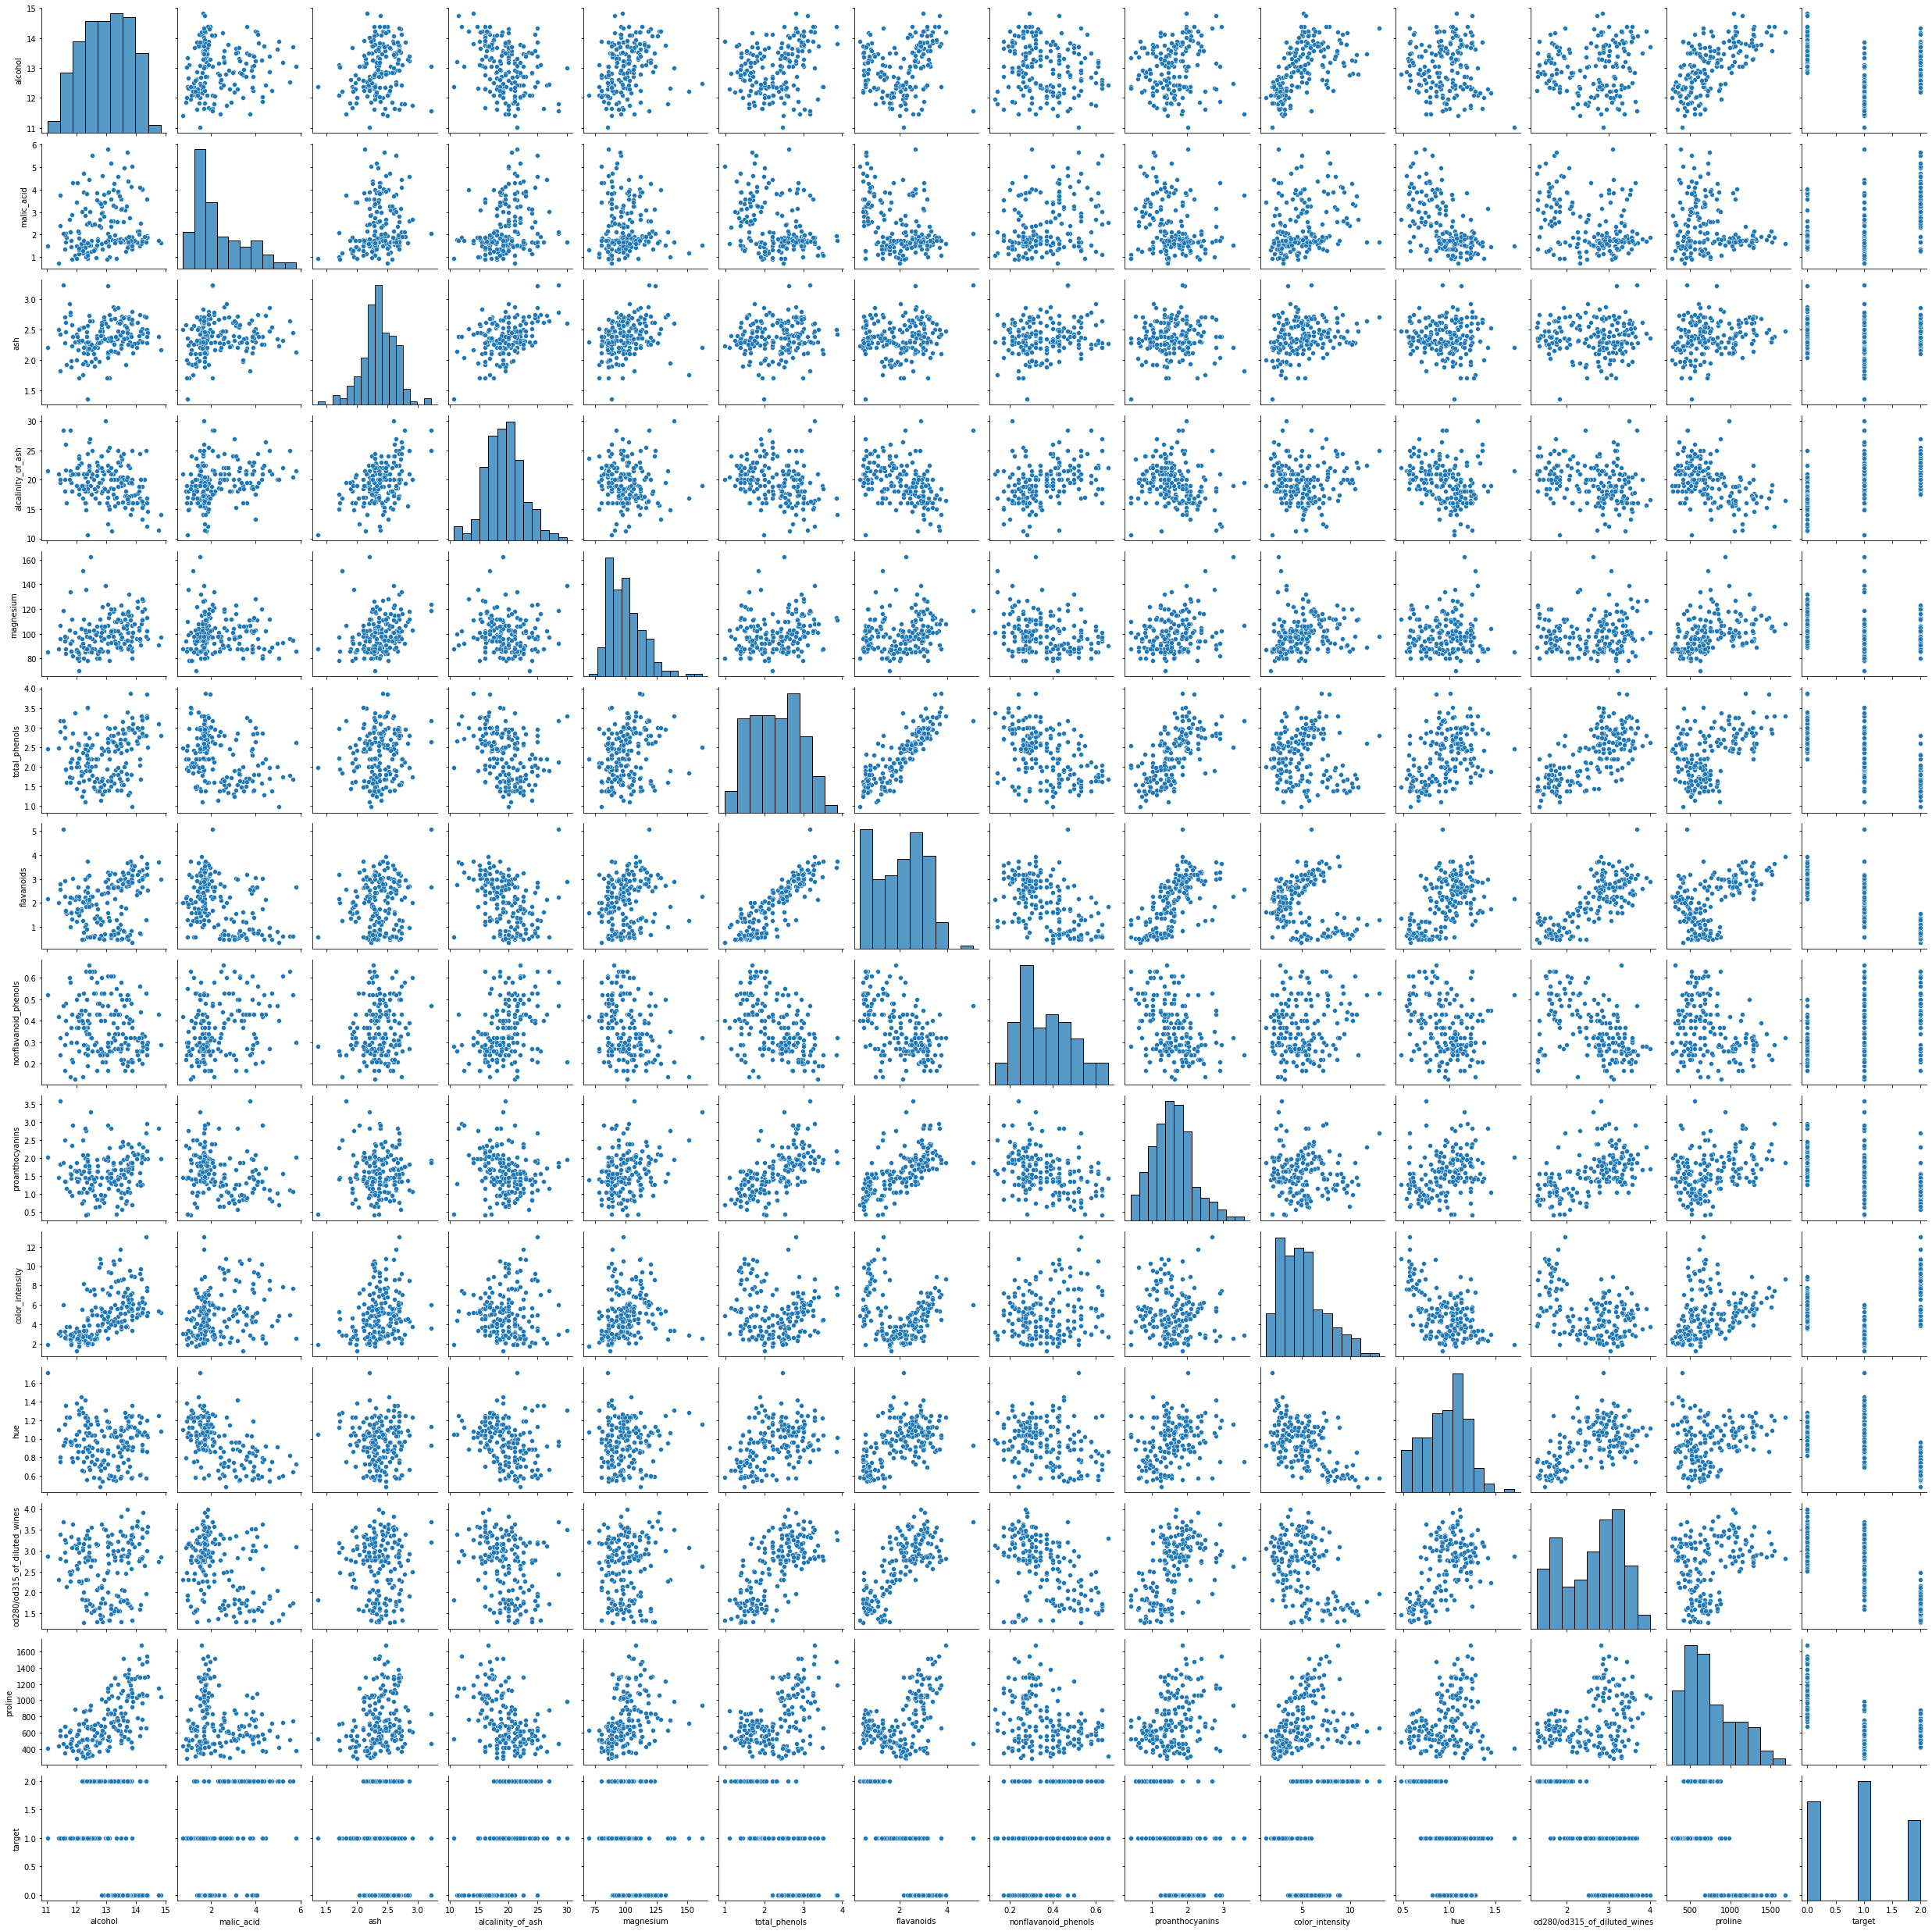

In [ ]:
#This part shows the data in a matrix plot. if you wan to see them just uncomment
#the code but to execute it, it would take more than 2 minutes.
#%matplotlib inline
#sns.pairplot(X)

In [ ]:
X, y = X.drop(columns = 'target'), X['target']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
%%time
model = ID3(max_depth = 13, min_samples_leaf=2, min_samples_split=2)
model.fit(X_train, y_train)


CPU times: user 6.39 s, sys: 1.91 ms, total: 6.39 s
Wall time: 6.4 s


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print(f'Accuracy for Wine dataset is {accuracy_score(y_test, y_pred)}')

Accuracy for Wine dataset is 0.9444444444444444


In [ ]:
%%time 

from sklearn.tree import DecisionTreeClassifier
lib_model = DecisionTreeClassifier(max_depth = 10)
lib_model.fit(X_train, y_train)
y_pred = lib_model.predict(X_test)
print(f'Accuracy for sklearn Decision Tree {accuracy_score(y_test, y_pred)}')

Accuracy for sklearn Decision Tree 0.9444444444444444
CPU times: user 39.8 ms, sys: 12 ms, total: 51.7 ms
Wall time: 138 ms


In [ ]:
iris = load_iris()
Xd, yd = iris['data'], iris['target']
Xd = pd.DataFrame(Xd)
Xd['target'] = yd
Xd.head()

,0,1,2,3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


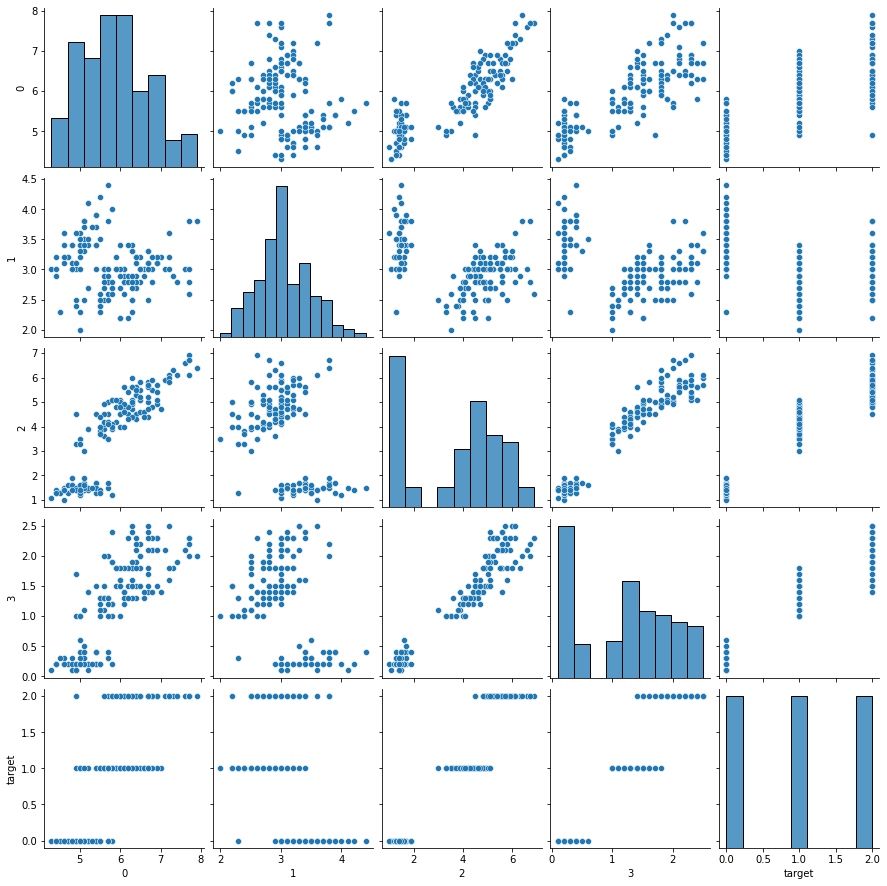

In [ ]:
%matplotlib inline
sns.pairplot(Xd)

In [ ]:
Xd, yd = Xd.drop(columns = 'target'), Xd['target']
Xd_train, Xd_test, yd_train, yd_test = \
    train_test_split(Xd, yd, test_size=0.30, random_state=42)

In [ ]:
m = ID3(max_depth = 4, min_samples_leaf=2, min_samples_split=2)

In [ ]:
m.fit(Xd_train, yd_train)

In [ ]:
yd_pred = m.predict(Xd_test)
print(f'Accuracy for Iris dataset is {accuracy_score(yd_test, yd_pred)}')

Accuracy for Iris dataset is 1.0
